In [1]:
import datetime
import Factor_classes

import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
# se togli i seguenti ticker da Tickers.json, la strategia migliore diventa random forest:
#"IG.MI", "LDO.MI", "REC.MI",
#"STLAM.MI", "STMMI.MI", "TRN.MI", 
#"AZM.MI", "BPSO.MI", "ERG.MI"

In [3]:
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2024, 6, 1)

stock_data = Factor_classes.StockData(start_date, end_date)
returns = stock_data.returns
index_returns = stock_data.index_returns

In [4]:
returns.tail(3)

Ticker,A2A.MI,AMP.MI,AZM.MI,BAMI.MI,BC.MI,BMED.MI,BMPS.MI,BPE.MI,BPSO.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLAM.MI,STMMI.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2024-03-31,-0.080933,0.029801,0.032146,0.081200,0.208061,0.057855,0.183642,0.119796,-0.010776,-0.000213,...,0.014498,0.246923,-0.039876,0.200835,0.033386,0.106757,0.005378,-0.069054,0.155205,0.302398
2024-04-30,-0.000298,0.077814,-0.058537,0.146504,-0.056808,0.012974,0.092568,0.163413,-0.001452,-0.007455,...,-0.014098,0.376608,0.003692,0.075445,-0.047929,0.132479,-0.197218,0.058677,0.135961,0.040833
2024-05-31,0.109884,-0.043556,-0.011558,0.006776,-0.077438,-0.000985,0.105012,0.134713,0.154909,0.010515,...,-0.019589,-0.059539,-0.016092,-0.207224,-0.086886,-0.159299,-0.009773,-0.008627,-0.016997,0.079487


In [5]:
correlation_matrix = Factor_classes.CorrelationMatrix(returns)
#correlation_matrix.plot_heatmap()

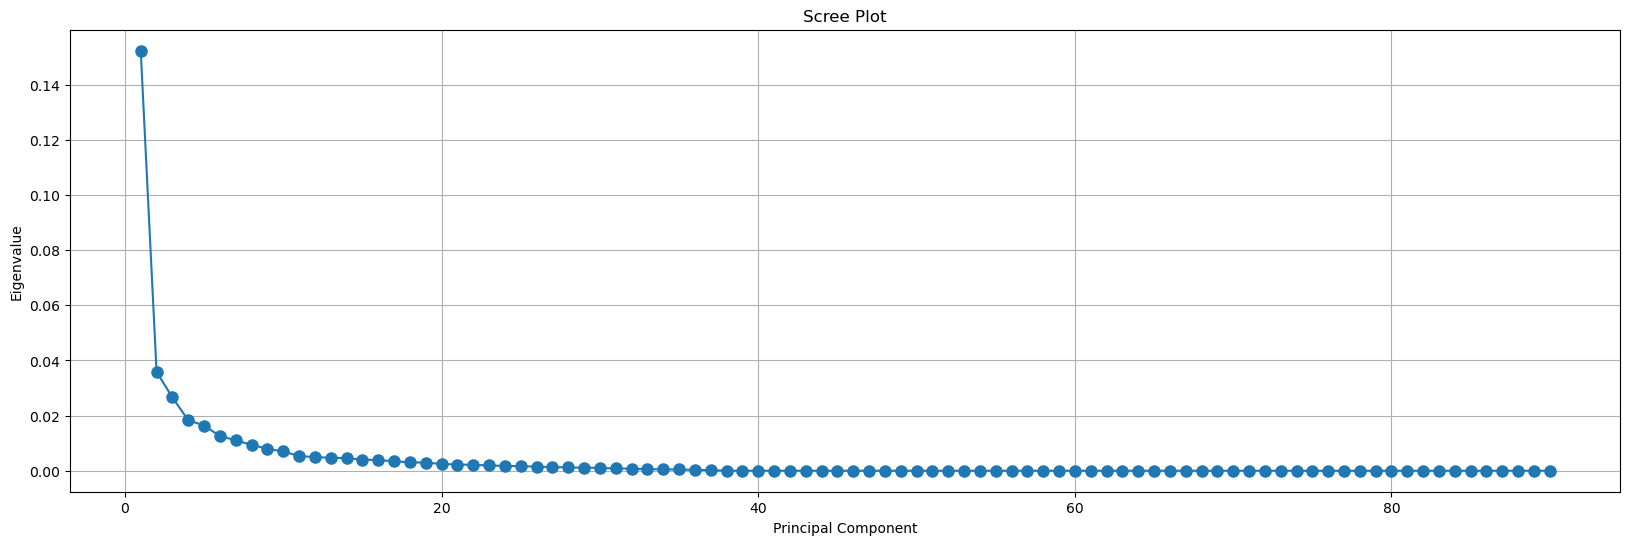

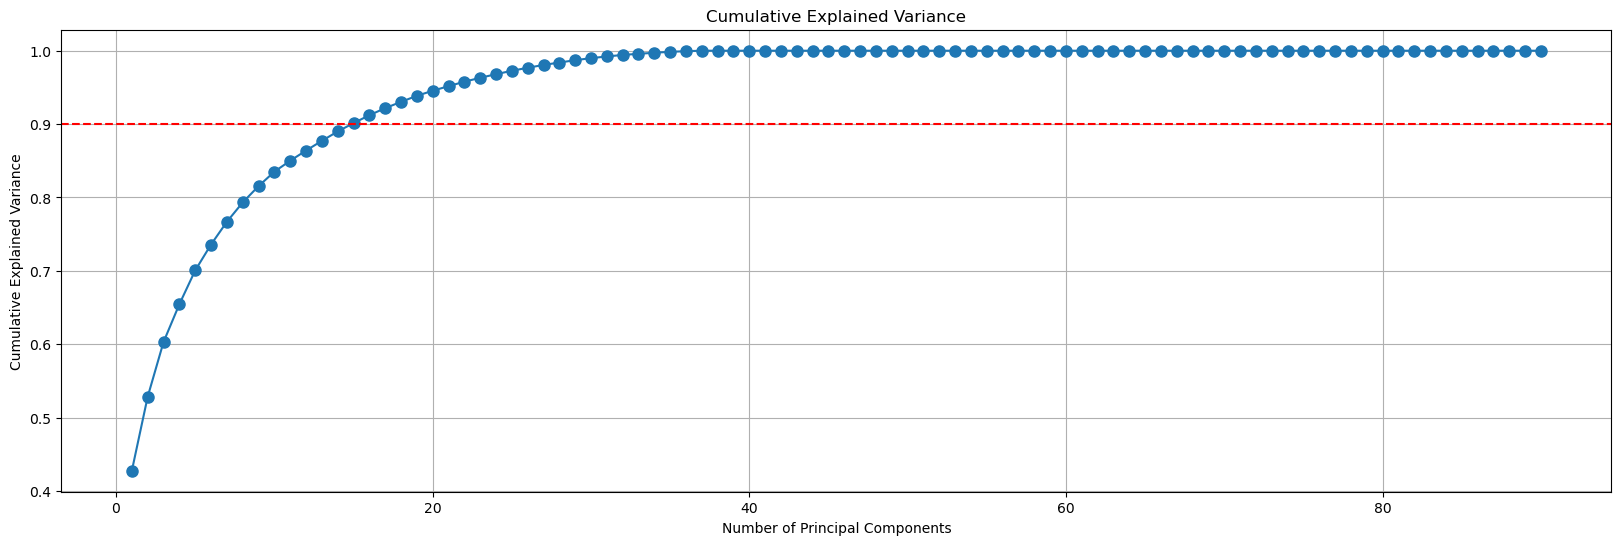

In [6]:
pca_analysis = Factor_classes.ComponentsAnalysis(stock_data.returns)
pca_analysis.plot_scree()
pca_analysis.plot_cumulative_explained_variance()

In [7]:
"""
m = 16 #explained variance 95
window_size = 36
max_iterations = 10000
factor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)

U_m_final = factor_model.U_m_final
F_final = factor_model.F_final
B_final = factor_model.B_final
"""

'\nm = 16 #explained variance 95\nwindow_size = 36\nmax_iterations = 10000\nfactor_model = Factor_classes.APCA(returns, max_iterations=max_iterations)\n\nU_m_final = factor_model.U_m_final\nF_final = factor_model.F_final\nB_final = factor_model.B_final\n'

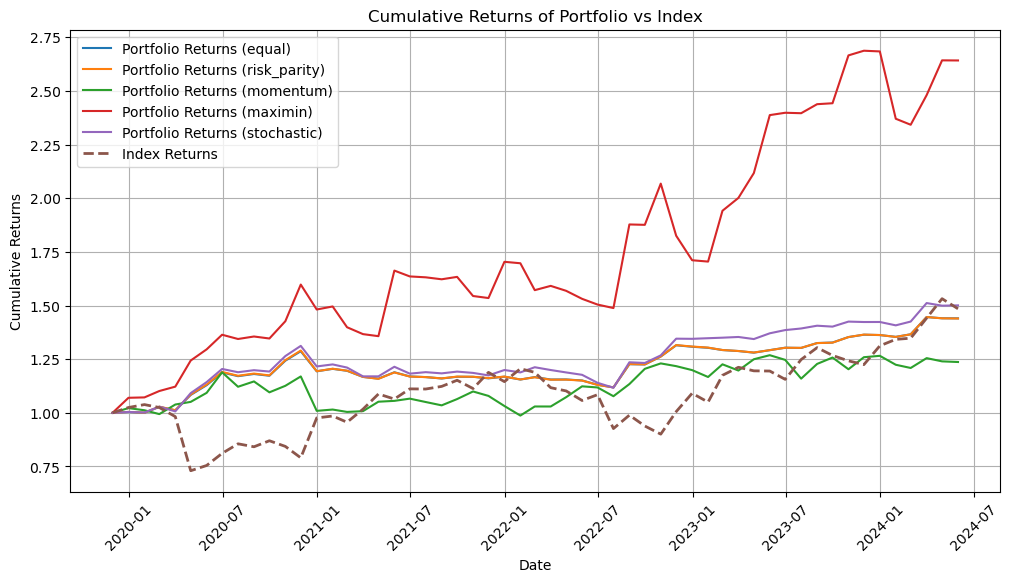

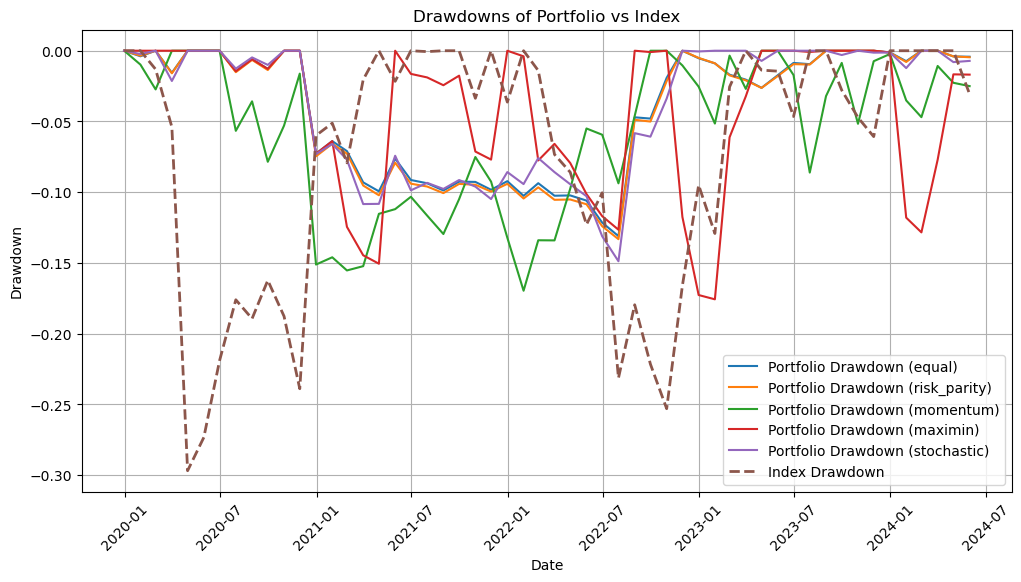

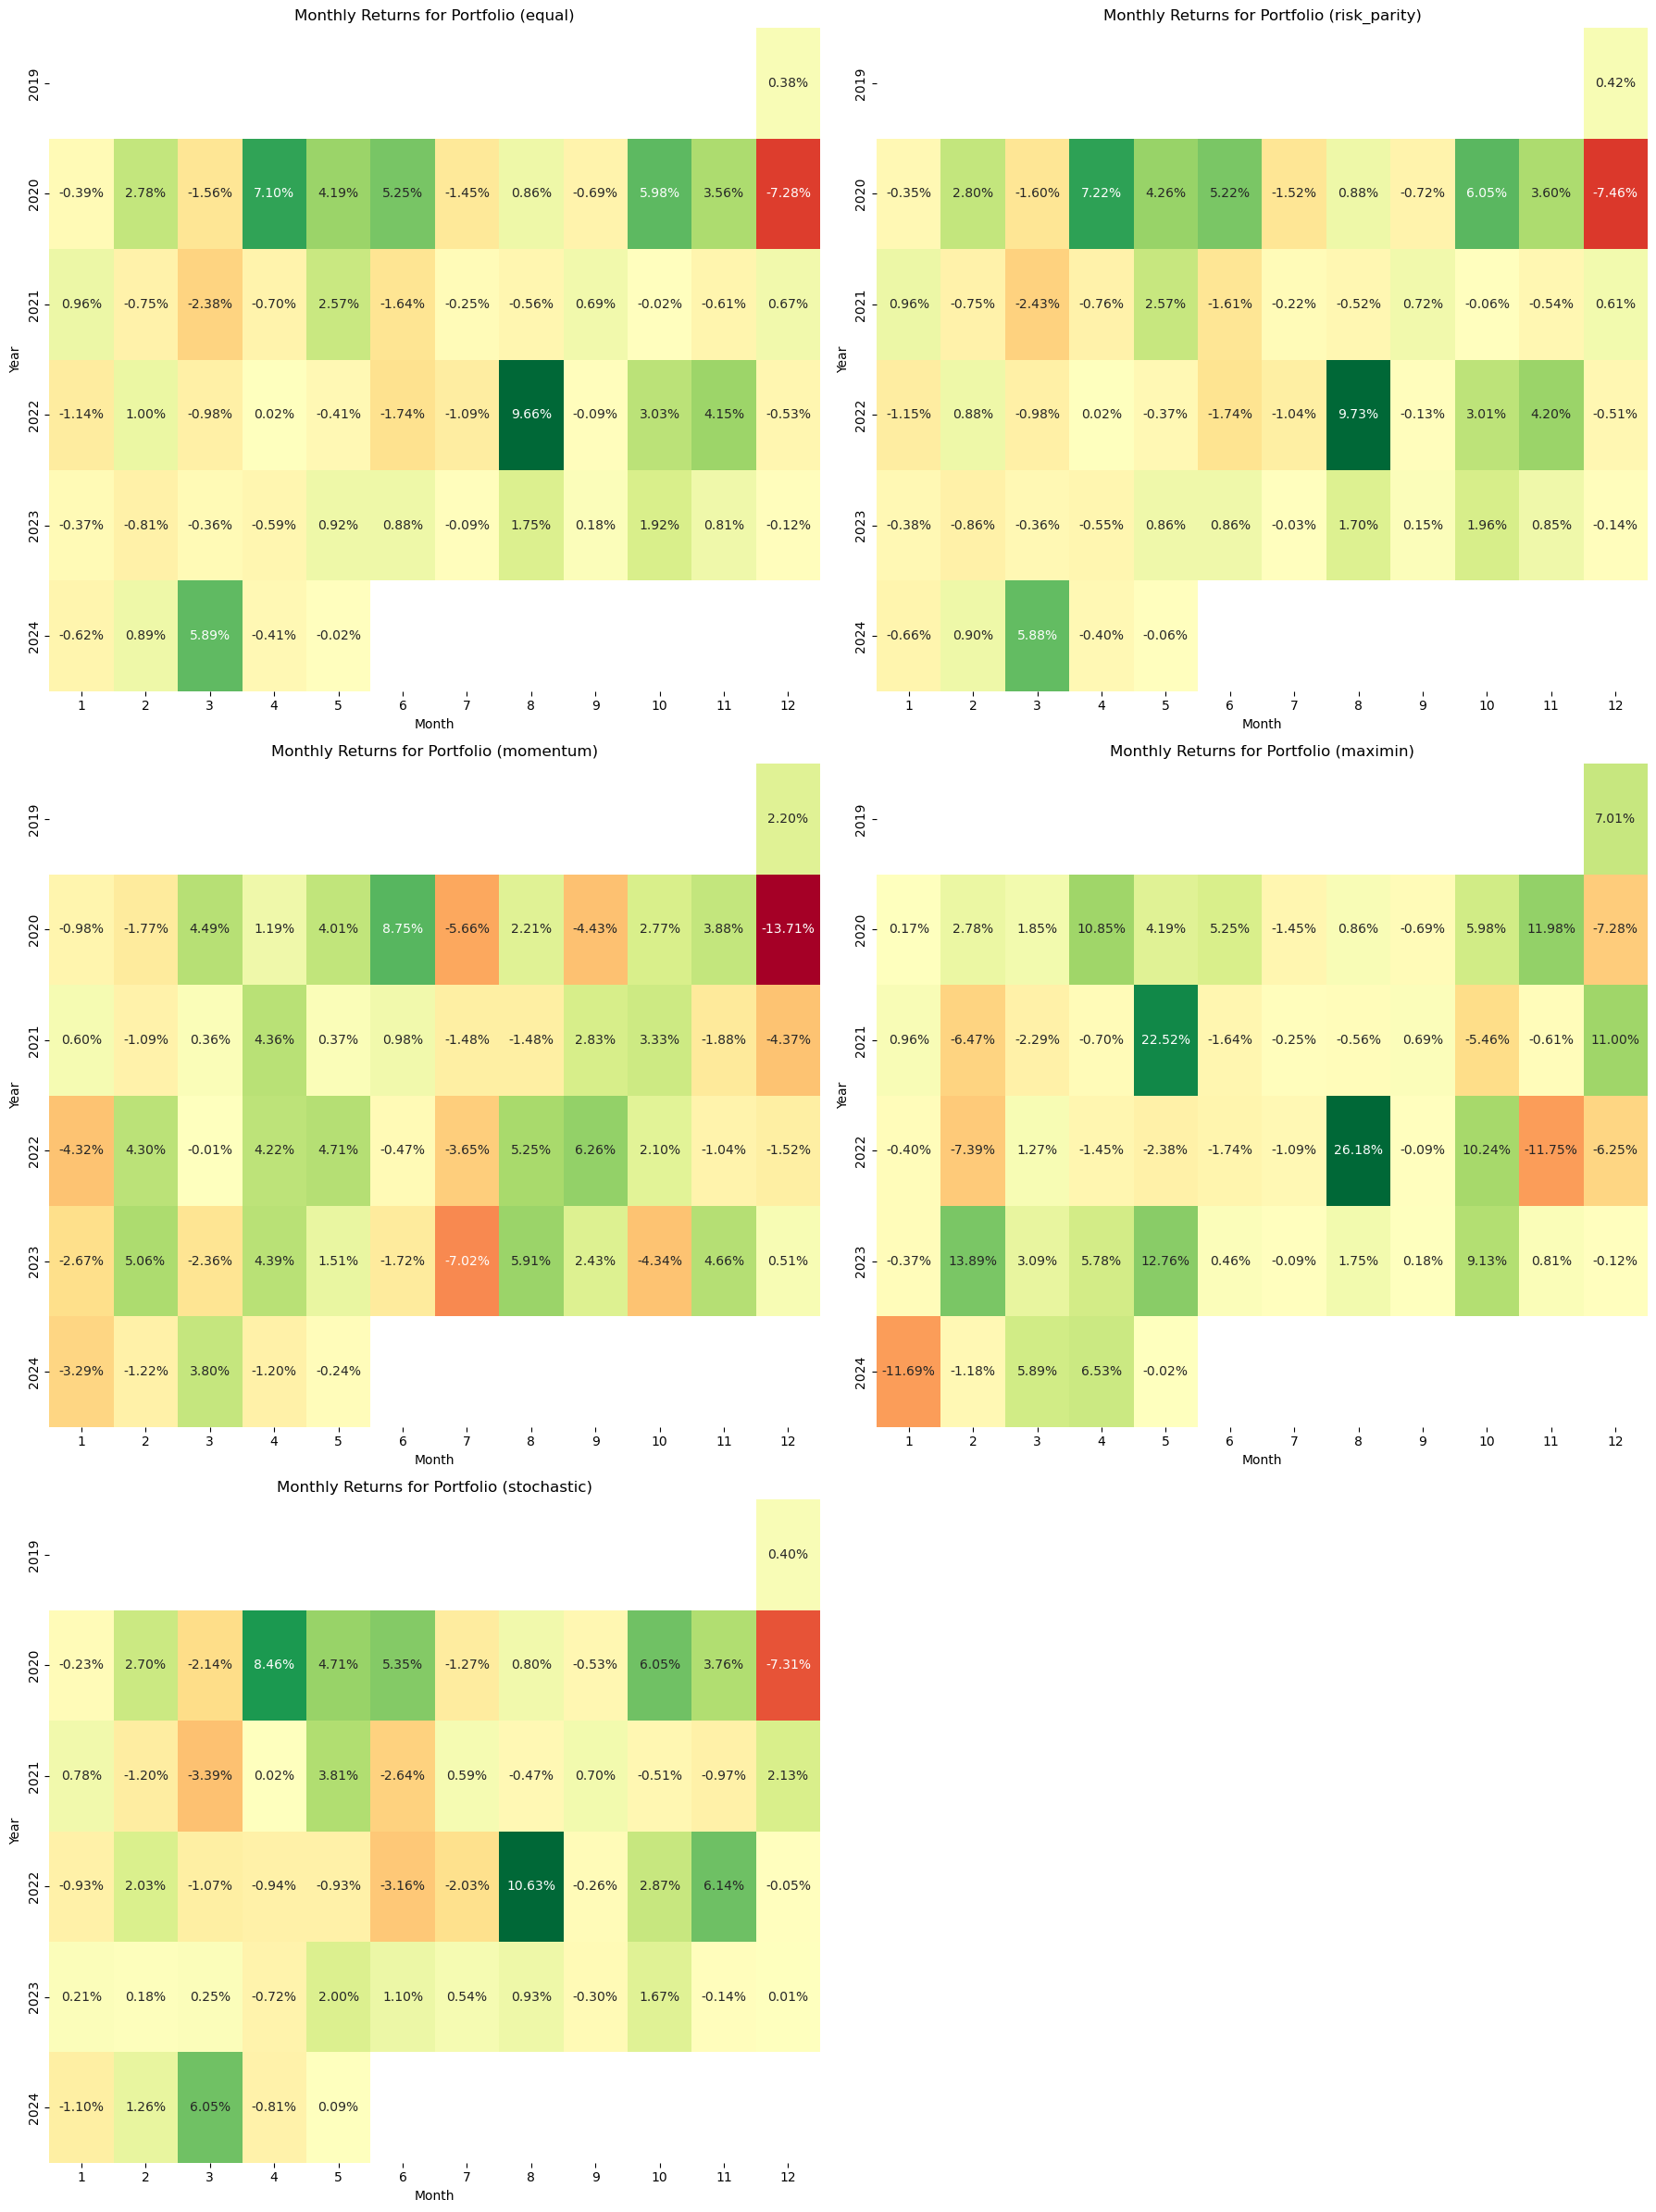

In [8]:
#con window size = 24, risultati ottimi con Random Forest
strategy = Factor_classes.RollingAPCAStrategy(returns, window_size=36, max_iterations=1000, transaction_cost=0.001, slippage=0.001)
index_cum_returns, portfolio_cum_returns = strategy.evaluate_strategies(index_returns)

In [9]:
index_test_rets = pd.DataFrame(index_cum_returns)
index_test_rets.rename(columns={'Open': 'Benchmark'}, inplace=True)

index_test_rets.head(3)

,Benchmark
Date,
2019-12-31,0.024764
2020-01-31,0.013263
2020-02-29,-0.013132


In [10]:
index_stats = Factor_classes.FinancialMetrics.summary_stats(index_test_rets)

index_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
Benchmark,0.0918,0.2415,0.18,-0.4561,7.1267,0.0611,0.1067,0.1551,1.5024,0.2489,0.3339,0.2025,0.522,-0.2968,1.6338,1,0,0,0,1.5722


In [11]:
portfolio_test_rets = pd.DataFrame(portfolio_cum_returns)

portfolio_test_rets.head(3)

,equal,risk_parity,momentum,maximin,stochastic
2019-12-31,0.003841,0.004249,0.021985,0.070070,0.003962
2020-01-31,-0.003917,-0.003540,-0.009804,0.001669,-0.002341
2020-02-29,0.027804,0.027961,-0.017709,0.027804,0.027040


In [12]:
portfolio_stats = Factor_classes.FinancialMetrics.summary_stats(portfolio_test_rets, market=index_test_rets)

portfolio_stats

,Annualized Return,Annualized Volatility,Semi-Deviation,Skewness,Kurtosis,Historic VaR (5%),Cornish-Fisher VaR (5%),Historic CVaR (5%),Return on VaR,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Modified Burke Ratio,Max Drawdown,Net Profit to Worst Drawdown,Beta,Treynor Ratio,Tracking Error,Information Ratio,Tail Ratio
equal,0.0845,0.0922,0.0466,0.8599,5.6407,0.0167,0.0281,0.0380,5.0471,0.5746,1.1537,0.4045,0.8890,-0.1310,3.3610,-0.1112,-0.4767,0.0815,-0.8550,3.5385
risk_parity,0.0843,0.0932,0.0478,0.8365,5.7042,0.0166,0.0286,0.0388,5.0854,0.5673,1.1231,0.3970,0.8662,-0.1332,3.3005,-0.1141,-0.4635,0.0818,-0.8560,3.5816
momentum,0.0484,0.1374,0.0996,-0.7490,4.5135,0.0486,0.0666,0.0880,0.9951,0.1300,0.1793,0.1053,0.2293,-0.1696,1.3963,-0.1339,-0.1333,0.0879,-1.1962,1.1286
maximin,0.2410,0.2463,0.1222,1.0669,5.1219,0.0731,0.0695,0.1027,3.2949,0.8336,1.7010,1.1687,2.9932,-0.1757,9.3475,-0.1970,-1.0422,0.1088,0.5567,1.7991
stochastic,0.0944,0.1042,0.0540,0.8709,4.9942,0.0282,0.0320,0.0462,3.3466,0.6014,1.1911,0.4212,1.0334,-0.1488,3.3654,-0.1056,-0.5935,0.0824,-0.7354,2.1566
